# Open Video

In [2]:
# can we use a file picker here? That would be fancy
from ipyfilechooser import FileChooser

# Create and display a FileChooser widget
fc = FileChooser()
display(fc)

FileChooser(path='/home/alubitz/repos/VVAD/examples', filename='', title='HTML(value='', layout=Layout(display…

# Create Samples

In [11]:
# Here I can use what I did in the liveCam.py before
from collections import defaultdict

import cv2
import dlib
from dvg_ringbuffer import RingBuffer
from vvadlrs3 import pretrained_models, sample, dlibmodels
from vvadlrs3.utils.imageUtils import cropImage
import numpy as np

model = pretrained_models.getFaceImageModel() # model for predictions
k = 36  # Number of frames used for inference
shape = (96, 96)  # Resolution of the input imgae for the prediction
featureType = 'faceImage'  # Type of the features that will be created from the Image
# TODO: this should actually only be needed if not using faceImage type
shapeModelPath = str(dlibmodels.SHAPE_PREDICTOR_68_FACE_LANDMARKS())
ffg = sample.FaceFeatureGenerator(
    featureType, shapeModelPath=shapeModelPath, shape=shape)

# TODO: Fist approach only with a detector - later we can try FaceTracker for multiple faces?
detector = dlib.get_frontal_face_detector()

# Ringbuffer for features
rb = RingBuffer(36, dtype=(np.uint8, (96, 96, 3)))
video_path = fc.selected

### SAVE SAMPLES FOR EVALUATION? ###
save_sample = False

# Opens the Video file
cap= cv2.VideoCapture(video_path)
i=0
frame_scores = defaultdict(list)
samples = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    dets = detector(frame, 1)   # Detect faces
    if dets:
        features = ffg.getFeatures(cropImage(frame, dets[0]))
        # fill ringbuffer
        rb.append(features)

        if rb.is_full:
            y = model.predict(np.array([rb]))
            frame_scores[i].append(y)
            s = sample.FeaturedSample()
            s.data = np.copy(rb)
            s.label = y > 0.5
            s.featureType = featureType
            samples.append(s)
            if save_sample:
                s.save(f'{i}.pickle')
        #cv2.imshow('frame', frame) # TODO: could show frame i - (k-1)  

    else:
        # empty ringbuffer - to prevent glitches
        rb.clear()
    i+=1

cap.release()
cv2.destroyAllWindows()



# Visualize Samples

FileChooser(path='/home/alubitz/repos/VVAD/examples', filename='', title='HTML(value='', layout=Layout(display…

Path?
registered
shape: (36, 96, 96, 3)


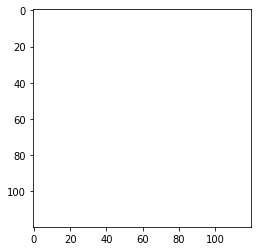

In [10]:
# Here I want to visualize some samples. Maybe one at random...
from ipyfilechooser import FileChooser
from vvadlrs3 import sample

# Create and display a FileChooser widget
fsc = FileChooser()
display(fsc)
print('Path?')


def on_select(chooser):
    sample_path = chooser.selected
    print(sample_path)
    chooser.title = '<b>Callback function executed</b>'
    s = sample.FeaturedSample() #TODO: this doesn't work because it is executed in a callback, that probably can't access the main Thread to draw something
    s.load(sample_path)
    s.visualize()

fsc.register_callback(on_select)
print('registered')

s = sample.FeaturedSample()
s.load('/home/alubitz/repos/VVAD/examples/100.pickle')
s.visualize() #TODO: this apperently does not work in the Notebook...Wasn't it working before?


# Anotate Video with prediction

We have predictions for 704 frames
/home/alubitz/anaconda3/envs/vvadlrs3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alubitz/anaconda3/envs/vvadlrs3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/alubitz/anaconda3/envs/vvadlrs3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alubitz/anaconda3/envs/vvadlrs3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/alubitz/anaconda3/envs/vvadlrs3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


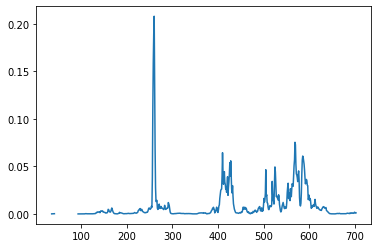

In [14]:
import matplotlib.pyplot as plt

# Sum up y for every frame - probably needs some normalization...how to handle the first/last k frames? they will have less predictions... 
# show summed prediction value as colored boundingbox between 0->red and 1->green? Or show a graph in the video that grows over time.

# Fist visualize the values of the frame_scores
max_frame = max(frame_scores.keys())
print(f'We have predictions for {max_frame} frames')
x = list(range(max_frame))
y = []
e = []
for i in x:
    values = frame_scores[i]
    y.append(np.mean(values))
    e.append(np.std(values))


plt.errorbar(x,y,e)
plt.show()


In [16]:
for i, sample in enumerate(samples):
    if sample.label:
        print(f'Sample {i} is positive')